# Full MIDI Music Transformer Training Dataset Maker (ver. 1.0)

# Tokenize midi files for transformer
***

Powered by tegridy-tools: https://github.com/asigalov61/tegridy-tools

***

#### Project Los Angeles

#### Tegridy Code 2023

***

In [1]:
import os

os.chdir('/ix/djishnu/Hanxi/PGM_Project/')

In [2]:
import sys
sys.path.insert(1, '/ix/djishnu/Aaron/2_misc/PGM_Project/Full-MIDI-Music-Transformer')

# (SETUP ENVIRONMENT)

In [3]:
#@title Import all needed modules

print('Loading needed modules. Please wait...')

import math
import statistics
import random
import pickle
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
print('Loading TMIDIX module...')

from tegridy_tools import TMIDIX

print('Done!')
print('Enjoy! :)')

Loading needed modules. Please wait...
Loading TMIDIX module...


ModuleNotFoundError: No module named 'tegridy_tools'

In [5]:
import matplotlib.pyplot as plt


In [6]:
import numpy as np

## (FILE LIST) (converting from MIDI)

In [4]:
# output_dir = 'outputs/'

output_dir = 'content/'

output_dir = 'content_tokenizing'/
# run_dir = 'improvised_1000token_hot_start/'

run_dir = 'gothic_horror_movies/'

# where midi files live
dataset_addr = output_dir + run_dir + 'midi'

# where to save 
pickle_file_name = output_dir + run_dir + 'file_list'
process_output_dir = output_dir + run_dir + 'processed'



if not os.path.exists(process_output_dir):
    os.makedirs(process_output_dir)



SyntaxError: invalid syntax (203219849.py, line 5)

In [12]:
# hsamp = pickle.load(open('/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/hmm_embed_token.pickle', 'rb'))

with open('/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/clean_midi/tokenized_midi464.pickle', 'rb') as f:
    hsamp = pickle.load(f)

In [6]:
# load embeddings
token_embeddings = np.array(pd.read_csv('/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/token_embeddings.csv', index_col=0))


## token embeddings

In [21]:
import sklearn
from sklearn import metrics

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(token_embeddings[0,:], hsamp[0][1])

In [7]:
import scipy

In [13]:
np.abs(1 - scipy.spatial.distance.cosine(token_embeddings[400,:], hsamp[0][1]))

0.027784616345037483

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
converted_tokens = []
converted_tokens_score = []

In [35]:
for mpos in range(len(hsamp[0])):
   best_match_index  = - 1
   best_match_score = 0

   queryvec = hsamp[0][1]
   for embdim in range(token_embeddings.shape[0]):

      d = np.abs(1 - scipy.spatial.distance.cosine(token_embeddings[embdim,:], hsamp[0][mpos]))
      if d > best_match_score:
         best_match_score = d
         best_match_index = embdim
   
   converted_tokens.append(best_match_index)
   converted_tokens_score.append(best_match_score)


In [36]:
with open('/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/hmm_embed_token_map.pickle', 'wb') as f:
   pickle.dump(converted_tokens, f)

In [37]:
converted_tokens_pad = [1562, 1562, 1562, 1562, 1562, *converted_tokens, 1561, 1561, 1561, 1561, 1561]

## token -> midid

In [7]:
def convert_tokens_to_midi(song, song_name = '', output_dir = '', save_song = False):
    '''convert tokens back to midi notes
    returns midi as list and vector s for channels'''
    song_f = []

    time = 0
    dur = 0
    vel = 90
    pitch = 0
    channel = 0

    song_seq = []
    for j in range(0, len(song), 5): # creating penta seqs...
        song_seq.append(song[j:j+5])

    patch_list = [0] * 16
    patch_list[9] = 128

    channels_list = [0] * 16
    channels_list[9] = 1

    for s in song_seq: # decoding...

        # 1553 - pad token

        # 1554 - patch change token
        # 1555 - control change token
        # 1556 - key after touch token
        # 1557 - channel after touch token
        # 1558 - pitch wheel change token
        # 1559 - counters seq token

            # 1560 - outro token
            # 1561 - end token
            # 1562 - start token

            if s[0] < 256: # Note

                patch = s[0]
                time += (s[1]-256) * 16
                dur = (s[2]-256-128) * 32
                pitch = (s[3]-256-128-128) % 128
                vel = (s[4]-256-128-128-256)

                if patch in patch_list:
                    channel = patch_list.index(patch)
                    channels_list[channel] = 1

                else:
                    if 0 in channels_list:
                        channel = channels_list.index(0)
                        channels_list[channel] = 1
                        song_f.append(['patch_change', time, channel, patch])

                    else:
                        channel = 15
                        channels_list[channel] = 1
                        song_f.append(['patch_change', time, channel, patch])

                song_f.append(['note', time, dur, channel, pitch, vel])

            if s[0] == 1554: # patch change

                time += (s[1]-256) * 16
                channel = (s[2]-(256+128+128+256+128))
                patch = s[3]

                if channel != 9:
                    patch_list[channel] = patch
                else:
                    patch_list[channel] = patch + 128

                song_f.append(['patch_change', time, channel, patch])

            if s[0] == 1555: # control change

                time += (s[1]-256) * 16
                patch = s[2]
                controller = (s[3]-(256+128+128+256+128+16))
                controller_value = (s[4]-(256+128+128+256+128+16+128))

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['control_change', time, channel, controller, controller_value])

            if s[0] == 1556: # key after touch

                time += (s[1]-256) * 16
                patch = s[2]
                pitch = (s[3]-256-128-128) % 128
                vel = (s[4]-256-128-128-256)

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['key_after_touch', time, channel, pitch, vel])

            if s[0] == 1557: # channel after touch

                time += (s[1]-256) * 16
                patch = s[2]
                vel = (s[3]-256-128-128-256)

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['channel_after_touch', time, channel, vel])

            if s[0] == 1558: # pitch wheel change

                time += (s[1]-256) * 16
                patch = s[2]
                pitch_wheel = (s[3]-(256+128+128+256+128+16+128)) * 128

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['pitch_wheel_change', time, channel, pitch_wheel])

    song_out_path = None
    if save_song:
        song_out_path = output_dir + "/" + song_name
        TMIDIX.Tegridy_Any_Pickle_File_Writer(song_f, song_out_path)

    return song_f, s, song_out_path

In [30]:
def plot_song(song_f, s, title = '', plot_dims = (14, 5)):
    x = []
    y =[]
    c = []

    colors = ['red', 'yellow', 'green', 'cyan', 'blue', 'pink', 'orange', 'purple', 'gray', 'white', 'gold', 'silver', 'red', 'yellow', 'green', 'cyan']

    for s in song_f:
        if s[0] == 'note':
            x.append(s[1] / 1000)
            y.append(s[4])
            c.append(colors[s[3]])

    plt.figure(figsize=plot_dims)
    ax=plt.axes(title=title)
    ax.set_facecolor('black')

    plt.scatter(x,y, c=c)
    plt.xlabel("Time")
    plt.ylabel("Pitch")
    plt.show()

In [46]:
from midi2audio import FluidSynth

def convert_midi_to_music(song_path, song_name, out_path):
    
    fs = FluidSynth(sound_font='/ix/djishnu/Aaron/2_misc/PGM_Project/Figures/test_outputs/VintageDreamsWaves-v2.sf2')
    fs.midi_to_audio(song_path, out_path + '/' + song_name + '.wav')

### test functions

In [21]:
with open('/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/clean_midi/tokenized_midi464.pickle', 'rb') as f:
    hsamp = pickle.load(f)

In [39]:
# converted_tokens, s, song_path = convert_tokens_to_midi(hsamp[0], song_name = 'input_test',
#                                                 output_dir='/ix/djishnu/Aaron/2_misc/PGM_Project/Figures/test_outputs',
#                                                 save_song=True)
converted_tokens, s, _ = convert_tokens_to_midi(hsamp[0])


Tegridy Pickle File Writer
Removing old Dataset...
Dataset was saved as: /ix/djishnu/Aaron/2_misc/PGM_Project/Figures/test_outputs/input_test.pickle
Task complete. Enjoy! :)


In [55]:
TMIDIX.midi2score(hsamp[0])

ValueError: byte must be in range(0, 256)

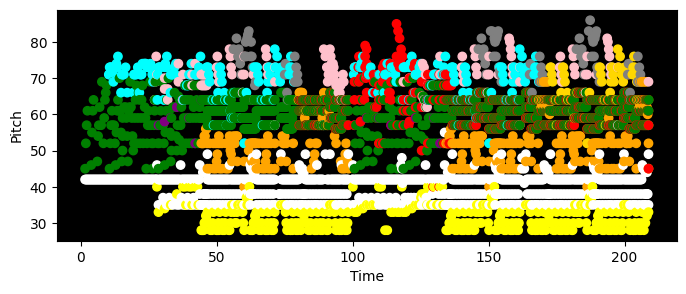

In [37]:
plot_song(converted_tokens, s, plot_dims=(8,3))

In [48]:
!which fluidsynth

which: no fluidsynth in (/ix/djishnu/Aaron/8_build/.conda/envs/gpu_midi_transformer_env/bin:/ihome/djishnu/aar126/.vscode-server/bin/abd2f3db4bdb28f9e95536dfa84d8479f1eb312d/bin/remote-cli:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin/:/ihome/djishnu/aar126/.local/bin:/ihome/djishnu/aar126/bin:/ihome/crc/pipx/bin/:/ihome/djishnu/aar126/.local/bin:/ihome/djishnu/aar126/bin:/ihome/djishnu/aar126/.vscode-server/bin/abd2f3db4bdb28f9e95536dfa84d8479f1eb312d/bin/remote-cli:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/ihome/crc/pipx/bin/:/ihome/djishnu/aar126/.local/bin:/ihome/djishnu/aar126/bin:/ihome/crc/pipx/bin/:/ihome/djishnu/aar126/.local/bin:/ihome/djishnu/aar126/bin)


In [53]:
TMIDIX.opus2midi(converted_tokens)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'

In [54]:
converted_tokens

[['control_change', 0, 0, 121, 0],
 ['control_change', 128, 0, 121, 0],
 ['control_change', 128, 0, 121, 0],
 ['control_change', 128, 0, 121, 0],
 ['control_change', 128, 0, 121, 0],
 ['control_change', 208, 0, 7, 92],
 ['control_change', 208, 0, 10, 84],
 ['control_change', 208, 0, 91, 96],
 ['control_change', 208, 0, 93, 0],
 ['control_change', 256, 0, 7, 114],
 ['control_change', 256, 0, 10, 64],
 ['control_change', 256, 0, 91, 0],
 ['control_change', 256, 0, 7, 115],
 ['control_change', 272, 0, 10, 74],
 ['control_change', 272, 0, 91, 96],
 ['control_change', 272, 0, 93, 25],
 ['control_change', 272, 0, 93, 44],
 ['control_change', 272, 0, 11, 127],
 ['pitch_wheel_change', 272, 0, 0],
 ['control_change', 272, 0, 121, 0],
 ['control_change', 272, 0, 121, 0],
 ['control_change', 272, 0, 11, 127],
 ['pitch_wheel_change', 272, 0, 0],
 ['control_change', 272, 0, 11, 127],
 ['pitch_wheel_change', 272, 0, 0],
 ['control_change', 272, 0, 11, 127],
 ['pitch_wheel_change', 272, 0, 0],
 ['con

In [49]:
convert_midi_to_music('/ix/djishnu/Aaron/2_misc/PGM_Project/Figures/test_outputs/input_test.pickle',
                      song_name = 'output_test', out_path = '/ix/djishnu/Aaron/2_misc/PGM_Project/Figures/test_outputs')

FileNotFoundError: [Errno 2] No such file or directory: 'fluidsynth'

In [44]:
import fluidsynth

In [45]:
fluidsynth

<module 'fluidsynth' from '/ix/djishnu/Aaron/8_build/.conda/envs/gpu_midi_transformer_env/lib/python3.8/site-packages/fluidsynth/__init__.py'>

In [58]:
TMIDIX.score2midi(hsamp[0])

TypeError: 'int' object is not iterable

In [59]:
ms_score = TMIDIX.midi2single_track_ms_score(open('/ix/djishnu/Aaron/2_misc/PGM_Project/content/clean_midi/"Weird Al" Yankovic/Amish Paradise.mid', 'rb').read(), recalculate_channels=False)

In [63]:
detailed_stats = TMIDIX.Tegridy_SONG_to_Full_MIDI_Converter(hsamp,
                                                                  output_signature = 'test_midi_output',
                                                                  output_file_name = '/ix/djishnu/Aaron/2_misc/PGM_Project/Figures/test_outputs/test',
                                                                  track_name='Project Los Angeles'
                                                                  )



Converting to MIDI. Please stand-by...


TypeError: object of type 'int' has no len()

# Redownload Lakh data

In [ ]:
#@title Download original LAKH MIDI Dataset


# !wget 'http://hog.ee.columbia.edu/craffel/lmd/lmd_full.tar.gz' -O '/ix/djishnu/Aaron/2_misc/PGM_Project/content/lakh_data/lmd_full.tar.gz'
# !tar -xvf 'lmd_full.tar.gz'
# !rm 'lmd_full.tar.gz'

# %cd /content/

In [ ]:
#@title Save file list
###########

print('Loading MIDI files...')
print('This may take a while on a large dataset in particular.')

dataset_addr = "/ix/djishnu/Aaron/2_misc/PGM_Project/content/lakh_data/lmd_full"
# os.chdir(dataset_addr)
filez = list()
for (dirpath, dirnames, filenames) in os.walk(dataset_addr):
    filez += [os.path.join(dirpath, file) for file in filenames]
print('=' * 70)

if filez == []:
    print('Could not find any MIDI files. Please check Dataset dir...')
    print('=' * 70)

print('Randomizing file list...')
random.shuffle(filez)

TMIDIX.Tegridy_Any_Pickle_File_Writer(filez, '/ix/djishnu/Aaron/2_misc/PGM_Project/content/lakh_data/file_list')

# from previous

In [27]:
def plot_song(song, title, end_pad = 0, plot_width = 14, plot_height = 5):

    song_f = []

    time = 0
    dur = 0
    vel = 90
    pitch = 0
    channel = 0

    son = []
    song1 = []
    for j in range(0, len(song), 5): # creating penta seqs...
        song1.append(song[j:j+5])

    patch_list = [0] * 16
    patch_list[9] = 128

    channels_list = [0] * 16
    channels_list[9] = 1

    for s in song1: # decoding...

        # 1553 - pad token

        # 1554 - patch change token
        # 1555 - control change token
        # 1556 - key after touch token
        # 1557 - channel after touch token
        # 1558 - pitch wheel change token
        # 1559 - counters seq token

            # 1560 - outro token
            # 1561 - end token
            # 1562 - start token

            if s[0] < 256: # Note

                patch = s[0]
                time += (s[1]-256) * 16
                dur = (s[2]-256-128) * 32
                pitch = (s[3]-256-128-128) % 128
                vel = (s[4]-256-128-128-256)

                if patch in patch_list:
                    channel = patch_list.index(patch)
                    channels_list[channel] = 1

                else:
                    if 0 in channels_list:
                        channel = channels_list.index(0)
                        channels_list[channel] = 1
                        song_f.append(['patch_change', time, channel, patch])

                    else:
                        channel = 15
                        channels_list[channel] = 1
                        song_f.append(['patch_change', time, channel, patch])

                song_f.append(['note', time, dur, channel, pitch, vel])

            if s[0] == 1554: # patch change

                time += (s[1]-256) * 16
                channel = (s[2]-(256+128+128+256+128))
                patch = s[3]

                if channel != 9:
                    patch_list[channel] = patch
                else:
                    patch_list[channel] = patch + 128

                song_f.append(['patch_change', time, channel, patch])

            if s[0] == 1555: # control change

                time += (s[1]-256) * 16
                patch = s[2]
                controller = (s[3]-(256+128+128+256+128+16))
                controller_value = (s[4]-(256+128+128+256+128+16+128))

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['control_change', time, channel, controller, controller_value])

            if s[0] == 1556: # key after touch

                time += (s[1]-256) * 16
                patch = s[2]
                pitch = (s[3]-256-128-128) % 128
                vel = (s[4]-256-128-128-256)

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['key_after_touch', time, channel, pitch, vel])

            if s[0] == 1557: # channel after touch

                time += (s[1]-256) * 16
                patch = s[2]
                vel = (s[3]-256-128-128-256)

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['channel_after_touch', time, channel, vel])

            if s[0] == 1558: # pitch wheel change

                time += (s[1]-256) * 16
                patch = s[2]
                pitch_wheel = (s[3]-(256+128+128+256+128+16+128)) * 128

                try:
                    channel = patch_list.index(patch)
                except:
                    channel = 15

                song_f.append(['pitch_wheel_change', time, channel, pitch_wheel])


    x = []
    y =[]
    c = []

    colors = ['red']#['red', 'yellow', 'green', 'cyan', 'blue', 'pink', 'orange', 'purple', 'gray', 'white', 'gold', 'silver', 'red', 'yellow', 'green', 'cyan']

    for s in song_f:
        if s[0] == 'note':
            x.append(s[1] / 1000)
            y.append(s[4])
            # c.append(colors[s[3]])
            c.append(colors[0])


    if end_pad > 0:
        pad_vec = [0] * end_pad

        x = [*x, *pad_vec]
        y = [*y, *pad_vec]
        c = [*c, *[colors[0] for x in range(end_pad)]]
    # if render_MIDI_to_audio:
    #     FluidSynth().midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))

    #     # FluidSynth("/usr/share/sounds/sf2/FluidR3_GM.sf2", 16000).midi_to_audio(str(fname + '.mid'), str(fname + '.wav'))

    #     display(Audio(str(fname + '.wav'), rate=16000))

    plt.figure(figsize=(plot_width,plot_height))
    ax=plt.axes(title=title)
    ax.set_facecolor('black')

    plt.scatter(x,y, c=c)
    plt.xlabel("Time")
    plt.ylabel("Pitch")
    plt.show()

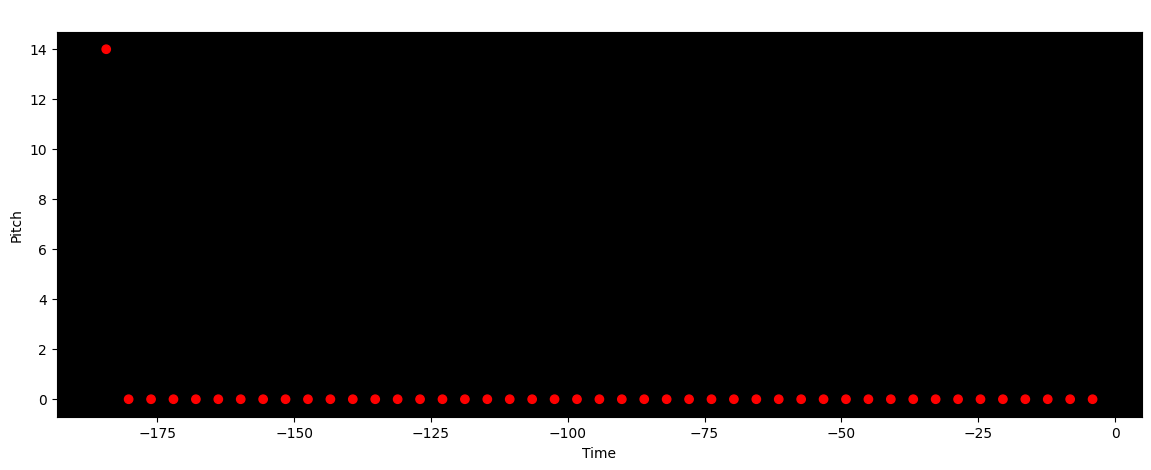

In [40]:
plot_song(converted_tokens, '')

In [37]:
#@title Save file list
###########

print('Loading MIDI files...')
print('This may take a while on a large dataset in particular.')

filez = list()
for (dirpath, dirnames, filenames) in os.walk(dataset_addr):
    filez += [os.path.join(dirpath, file) for file in filenames]
print('=' * 70)

if filez == []:
    print('Could not find any MIDI files. Please check Dataset dir...')
    print('=' * 70)

print('Randomizing file list...')
random.shuffle(filez)


# write file to pickle
TMIDIX.Tegridy_Any_Pickle_File_Writer(filez, pickle_file_name)


Loading MIDI files...
This may take a while on a large dataset in particular.
Randomizing file list...
Tegridy Pickle File Writer
Creating new Dataset file...
Dataset was saved as: content/gothic_horror_movies/file_list.pickle
Task complete. Enjoy! :)


## Process MIDI

In [6]:
with open('/ix/djishnu/Aaron/2_misc/PGM_Project/content/lakh_processed.pickle', 'rb') as f:
    filez = pickle.load(f)


process_output_dir = '/ix/djishnu/Aaron/2_misc/PGM_Project/content_tokenizing/lakh_tokenized'

In [9]:
with open('/ix/djishnu/Aaron/2_misc/PGM_Project/content/LAKH_INTs_0.pickle', 'rb') as f:
    sss = pickle.load(f)
sss

[]

In [8]:
filez

['lakh_clean/clean_midi/Robbie Williams/Eternity.1.mid',
 'lakh_clean/clean_midi/Chopin Frederic/Nocturne No. 1 in E minor, Op. 72: Andante.mid',
 'lakh_clean/clean_midi/Antonello Venditti/Giulio Cesare.mid',
 'lakh_clean/clean_midi/Madonna/Rain.7.mid',
 'lakh_clean/clean_midi/Queen/Bohemian Rhapsody.mid',
 'lakh_clean/clean_midi/Jackson Michael/Black or White.6.mid',
 'lakh_clean/clean_midi/Flamingos/I Only Have Eyes for You.mid',
 'lakh_clean/clean_midi/Paul Young/Come Back and Stay.mid',
 'lakh_clean/clean_midi/Rod Stewart/You Wear It Well.mid',
 'lakh_clean/clean_midi/Ozzy Osbourne/Suicide Solution.mid',
 'lakh_clean/clean_midi/The Beach Boys/Fun, Fun, Fun.4.mid',
 'lakh_clean/clean_midi/Grandi/Dolcissimo amore.mid',
 'lakh_clean/clean_midi/Mina/Una zebra a pois.1.mid',
 'lakh_clean/clean_midi/Los Bravos/Black Is Black.mid',
 "lakh_clean/clean_midi/E-Rotic/Max Don't Have Sex With Your Ex.mid",
 'lakh_clean/clean_midi/George Baker Selection/Una Paloma Blanca.2.mid',
 'lakh_clean/cle

In [7]:
#@title Process MIDIs with TMIDIX MIDI processor
print('=' * 70)
print('TMIDIX MIDI Processor')
print('=' * 70)
print('Starting up...')
print('=' * 70)

###########

START_FILE_NUMBER = 0
LAST_SAVED_BATCH_COUNT = 0

input_files_count = START_FILE_NUMBER
files_count = LAST_SAVED_BATCH_COUNT

melody_chords_f = []

stats = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

print('Processing MIDI files. Please wait...')
print('=' * 70)

for f in tqdm(filez[START_FILE_NUMBER:]):
    try:

      input_files_count += 1

      fn = os.path.basename(f)

      # Filtering out giant MIDIs
      file_size = os.path.getsize(f)

      if file_size < 250000:

        #=======================================================
        # START PROCESSING

        # Convering MIDI to ms score with MIDI.py module
        ms_score = TMIDIX.midi2single_track_ms_score(open(f, 'rb').read(), recalculate_channels=False)

        events_matrix1 = []

        itrack = 1

        events_types = ['note',
                        'patch_change',
                        'control_change',
                        'key_after_touch',
                        'channel_after_touch',
                        'pitch_wheel_change']

        while itrack < len(ms_score):
            for event in ms_score[itrack]:
                if event[0] in events_types:
                    events_matrix1.append(event)
            itrack += 1

        events_matrix1.sort(key = lambda x: (x[4] if x[0] == 'note' else x[1]), reverse = True)
        events_matrix1.sort(key = lambda x: x[1])

        if len(events_matrix1) > 0:
            if min([e[1] for e in events_matrix1]) >= 0 and min([e[2] for e in events_matrix1 if e[0] == 'note']) >= 0:

                #=======================================================
                # PRE-PROCESSING

                # recalculating timings
                for e in events_matrix1:
                    e[1] = int(e[1] / 16) # Max 2 seconds for start-times
                    if e[0] == 'note':
                        e[2] = int(e[2] / 32) # Max 4 seconds for durations

                #=======================================================
                # FINAL PRE-PROCESSING

                patch_list = [0] * 16
                patch_list[9] = 128

                melody_chords = []

                pe = events_matrix1[0]

                for e in events_matrix1:

                    if e[0] == 'note':

                        # Cliping all values...
                        time = max(0, min(127, e[1]-pe[1]))
                        dur = max(1, min(127, e[2]))
                        cha = max(0, min(15, e[3]))
                        ptc = max(1, min(127, e[4]))
                        vel = max(1, min(127, e[5]))
                        pat = patch_list[cha]

                        # Writing final note
                        melody_chords.append(['note', time, dur, cha, ptc, vel, pat])

                    if e[0] == 'patch_change':

                        # Cliping all values...
                        time = max(0, min(127, e[1]-pe[1]))
                        cha = max(0, min(15, e[2]))
                        ptc = max(0, min(127, e[3]))

                        if cha != 9:
                            patch_list[cha] = ptc
                        else:
                            patch_list[cha] = ptc+128

                        melody_chords.append(['patch_change', time, cha, ptc])

                    if e[0] == 'control_change':

                        # Cliping all values...
                        time = max(0, min(127, e[1]-pe[1]))
                        cha = max(0, min(15, e[2]))
                        con = max(0, min(127, e[3]))
                        cval = max(0, min(127, e[4]))

                        pat = patch_list[cha]

                        melody_chords.append(['control_change', time, pat, con, cval])

                    if e[0] == 'key_after_touch':

                        # Cliping all values...
                        time = max(0, min(127, e[1]-pe[1]))
                        cha = max(0, min(15, e[2]))
                        ptc = max(1, min(127, e[3]))
                        vel = max(1, min(127, e[4]))

                        pat = patch_list[cha]

                        melody_chords.append(['key_after_touch', time, pat, ptc, vel])

                    if e[0] == 'channel_after_touch':

                        # Cliping all values...
                        time = max(0, min(127, e[1]-pe[1]))
                        cha = max(0, min(15, e[2]))
                        vel = max(1, min(127, e[3]))

                        pat = patch_list[cha]

                        melody_chords.append(['channel_after_touch', time, pat, vel])

                    if e[0] == 'pitch_wheel_change':

                        # Cliping all values...
                        time = max(0, min(127, e[1]-pe[1]))
                        cha = max(0, min(15, e[2]))
                        wheel = max(-8192, min(8192, e[3])) // 128

                        pat = patch_list[cha]

                        melody_chords.append(['pitch_wheel_change', time, pat, wheel])

                    pe = e


                #=======================================================

                # Adding SOS/EOS, intro and counters

                if len(melody_chords) < (127 * 100) and ((events_matrix1[-1][1] * 16) < (8 * 60 * 1000)): # max 12700 MIDI events and max 8 min per composition

                    melody_chords1 = [['start', 0, 0, 0, 0, 0]]

                    events_block_counter = 0
                    time_counter = 0

                    for i in range(len(melody_chords)):
                        melody_chords1.append(melody_chords[i])

                        time_counter += melody_chords[i][1]

                        if i != 0 and (len(melody_chords) - i == 100):
                            melody_chords1.append(['outro', 0, 0, 0, 0, 0])

                        if i != 0 and (i % 100 == 0) and (len(melody_chords) - i >= 100):
                            melody_chords1.append(['counters_seq', ((time_counter * 16) // 3968), events_block_counter, 0, 0, 0])
                            events_block_counter += 1

                    melody_chords1.append(['end', 0, 0, 0, 0, 0])

                    #=======================================================

                    melody_chords2 = []

                    for m in melody_chords1:

                        if m[0] == 'note':

                            if m[3] == 9:
                                ptc = m[4] + 128
                            else:
                                ptc = m[4]

                            # Writing final note
                            melody_chords2.extend([m[6], m[1]+256, m[2]+256+128, ptc+256+128+128, m[5]+256+128+128+256])

                        # Total tokens so far 896

                        if m[0] == 'patch_change': # 896

                            melody_chords2.extend([1554, m[1]+256, m[2]+256+128+128+256+128, m[3], 1553])

                        # Total tokens so far 912

                        if m[0] == 'control_change': # 912

                            melody_chords2.extend([1555, m[1]+256, m[2], m[3]+256+128+128+256+128+16, m[4]+256+128+128+256+128+16+128])

                        # Total tokens so far 1168

                        if m[0] == 'key_after_touch': # 1168

                            if m[2] == 9:
                                ptc = m[3] + 128
                            else:
                                ptc = m[3]

                            melody_chords2.extend([1556, m[1]+256, m[2], ptc+256+128+128, m[4]+256+128+128+256])

                        # Total tokens so far 1168

                        if m[0] == 'channel_after_touch': # 1168

                            melody_chords2.extend([1557, m[1]+256, m[2], m[3]+256+128+128+256, 1553])

                        # Total tokens so far 1168

                        if m[0] == 'pitch_wheel_change': # 1168

                            melody_chords2.extend([1558, m[1]+256, m[2], m[3]+256+128+128+256+128+16+128, 1553])

                        # Total tokens so far 1296

                        if m[0] == 'counters_seq': # 1296

                            melody_chords2.extend([1559, m[1]+256+128+128+256+128+16+128+128, m[2]+256+128+128+256+128+16+128+128+128, 1553, 1553])

                        # Total tokens so far: 1552

                        #=======================================================

                        # 1553 - pad token

                        # 1554 - patch change token
                        # 1555 - control change token
                        # 1556 - key after touch token
                        # 1557 - channel after touch token
                        # 1558 - pitch wheel change token
                        # 1559 - counters seq token

                        # 1560 - outro token
                        # 1561 - end token
                        # 1562 - start token

                        if m[0] == 'outro':
                            melody_chords2.extend([1560, 1560, 1560, 1560, 1560])

                        if m[0] == 'end':
                            melody_chords2.extend([1561, 1561, 1561, 1561, 1561])

                        if m[0] == 'start':
                            melody_chords2.extend([1562, 1562, 1562, 1562, 1562])

                    #=======================================================

                    # FINAL TOTAL TOKENS: 1562

                    #=======================================================

                    melody_chords_f.append(melody_chords2)

                    #=======================================================

                    # Processed files counter
                    files_count += 1

                    # Saving every 5000 processed files
                    if files_count % 5000 == 0:
                      print('SAVING !!!')
                      print('=' * 70)
                      print('Saving processed files...')
                      print('=' * 70)
                      print('Processed so far:', files_count, 'out of', input_files_count, '===', files_count / input_files_count, 'good files ratio')
                      print('=' * 70)
                      count = str(files_count)
                      TMIDIX.Tegridy_Any_Pickle_File_Writer(melody_chords_f, process_output_dir+ '/' +count)
                      melody_chords_f = []
                      print('=' * 70)

    except KeyboardInterrupt:
        print('Saving current progress and quitting...')
        break

    except Exception as ex:
        print('WARNING !!!')
        print('=' * 70)
        print('Bad MIDI:', f)
        print('Error detected:', ex)
        print('=' * 70)
        continue

# Saving last processed files...
print('SAVING !!!')
print('=' * 70)
print('Saving processed files...')
print('=' * 70)
print('Processed so far:', files_count, 'out of', input_files_count, '===', files_count / input_files_count, 'good files ratio')
print('=' * 70)
count = str(files_count)
TMIDIX.Tegridy_Any_Pickle_File_Writer(melody_chords_f, process_output_dir+ '/'+count)

# Displaying resulting processing stats...
print('=' * 70)
print('Done!')
print('=' * 70)

print('Resulting Stats:')
print('=' * 70)
print('Total good processed MIDI files:', files_count)
print('=' * 70)

TMIDIX MIDI Processor
Starting up...
Processing MIDI files. Please wait...


 36%|███▋      | 6268/17259 [00:00<00:00, 62676.32it/s]

WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Robbie Williams/Eternity.1.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Robbie Williams/Eternity.1.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Chopin Frederic/Nocturne No. 1 in E minor, Op. 72: Andante.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Chopin Frederic/Nocturne No. 1 in E minor, Op. 72: Andante.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Antonello Venditti/Giulio Cesare.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Antonello Venditti/Giulio Cesare.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Madonna/Rain.7.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Madonna/Rain.7.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Queen/Bohemian Rhapsody.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Queen/Bohemian Rhapsody.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_

 73%|███████▎  | 12536/17259 [00:00<00:00, 54116.35it/s]

WARNING !!!
Bad MIDI: lakh_clean/clean_midi/blink-182/Reckless Abandon.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/blink-182/Reckless Abandon.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/2 Unlimited/No Limit.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/2 Unlimited/No Limit.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Brown James/I Got the Feelin.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Brown James/I Got the Feelin.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Metallica/Master of Puppets.4.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Metallica/Master of Puppets.4.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Morandi/In ginocchio da te.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Morandi/In ginocchio da te.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/The Beatles/I Just Don't Understand.mid
Err

100%|██████████| 17259/17259 [00:00<00:00, 54137.76it/s]

WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Ryan Paris/La Dolce Vita.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Ryan Paris/La Dolce Vita.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Nirvana/Heart-Shaped Box.2.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Nirvana/Heart-Shaped Box.2.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/The Beatles/Hello Goodbye.4.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/The Beatles/Hello Goodbye.4.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/Bobby Darin/Mack the Knife.mid
Error detected: [Errno 2] No such file or directory: 'lakh_clean/clean_midi/Bobby Darin/Mack the Knife.mid'
WARNING !!!
Bad MIDI: lakh_clean/clean_midi/John Elton/I Don't Wanna Go On With You Like That.3.mid
Error detected: [Errno 2] No such file or directory: "lakh_clean/clean_midi/John Elton/I Don't Wanna Go On With You Like That.3.mid"
WARNING !!!
Bad MIDI: lakh_clean/clea

NameError: name 'TMIDIX' is not defined

# Review tokens vs embeddings

In [10]:
# load tokens
processed_tokens = pickle.load(open('outputs/improvised_1000token_hot_start/processed/1600.pickle', 'rb'))
processed_tokens[0][0:10]

[1562, 1562, 1562, 1562, 1562, 0, 256, 400, 584, 858]

In [21]:
# load embeddings
import pandas as pd

tok_emb = pd.read_csv('outputs/token_embeddings.csv', index_col = 0)
tok_emb.shape

(1564, 1024)

In [22]:
tok_emb

0         1         2         3         4         5         6  \
0    -0.015192  0.003599 -0.019196  0.001792  0.039326  0.004723 -0.049369   
1    -0.022339  0.015761 -0.026182 -0.012664  0.061391 -0.026766  0.004622   
2    -0.057360  0.076461 -0.054345  0.048821 -0.025212  0.052886 -0.027533   
3     0.000895 -0.021358  0.065856 -0.056469  0.029141  0.039494  0.006126   
4     0.052901  0.053114 -0.072045  0.039608  0.022100  0.089289 -0.050992   
...        ...       ...       ...       ...       ...       ...       ...   
1559 -0.066905 -0.033960  0.003042 -0.088536 -0.002154  0.069784 -0.062322   
1560 -0.018791 -0.018934 -0.001764 -0.080451  0.090459  0.129653 -0.084344   
1561 -0.030252  0.022476  0.044794 -0.041281  0.068326  0.145776  0.014970   
1562 -0.012751  0.016580 -0.056606 -0.009257  0.071401  0.057218 -0.041208   
1563 -0.017445  0.061681  0.057131 -0.034660 -0.036149  0.054009  0.028964   

             7         8         9  ...      1014      1015      1016  \
0     0.024487 -0.012655 -0.053168  ...  0.003751 -0.105459 -0.107325   
1     0.051164 -0.021827 -0.027289  ...  0.009449 -0.023462 -0.022690   
2     0.050693 -0.051102  0.019295  ... -0.046522  0.054373 -0.002728   
3     0.050121 -0.022464 -0.072609  ...  0.023876  0.065507  0.002722   
4    -0.044449  0.037566 -0.010225  ... -0.015442  0.011582 -0.072326   
...        ...       ...       ...  ...       ...       ...       ...   
1559 -0.023428 -0.016692  0.054002  ...  0.029196  0.051201  0.021750   
1560  0.032379 -0.020522 -0.013878  ... -0.010448  0.048958 -0.009346   
1561  0.024109 -0.086809  0.013287  ... -0.093288  0.047329  0.018072   
1562  0.031266 -0.000833  0.011626  ...  0.077858 -0.004683  0.025705   
1563 -0.012964 -0.060099  0.026142  ... -0.033433 -0.072556  0.107162   

          1017      1018      1019      1020      1021      1022      1023  
0     0.051786  0.007324  0.054284  0.067747 -0.013233 -0.013512  0.040906  
1     0.051649 -0.058472  0.028243  0.078143  0.068905  0.013547  0.020063  
2    -0.012254 -0.114398 -0.023583  0.001647 -0.024949 -0.038691 -0.025805  
3    -0.037692 -0.013292 -0.033982 -0.023621  0.062777  0.015091  0.025285  
4     0.022354  0.000728  0.006188  0.074577  0.050669  0.045003  0.116226  
...        ...       ...       ...       ...       ...       ...       ...  
1559  0.065399 -0.049420 -0.051240  0.045304  0.016880  0.038385 -0.022509  
1560 -0.022711 -0.016448  0.016557  0.022000 -0.027989  0.030070 -0.021808  
1561 -0.029469 -0.045874  0.002700  0.008204 -0.064660  0.003252  0.033479  
1562 -0.035007  0.090887  0.029113  0.021445  0.017215 -0.060239  0.048306  
1563  0.048982 -0.030019  0.043539 -0.115727 -0.040635 -0.051412 -0.005214  

[1564 rows x 1024 columns]

In [19]:
import numpy as np
np.min(processed_tokens[0])

0

# Prepare to tokenize

In [73]:
# where midi files live
dataset_addr = output_dir + run_dir + 'processed'

In [75]:
CHUNKS_LENGTH = 4096+4 # must be larger than model seq_len and must be divisible by 5
MIN_NUMBER_OF_CHUNK_EVENTS = 102 # min number of MIDI events per chunk
PAD_IDX = 1563 # model pad index

filez = list()
for (dirpath, dirnames, filenames) in os.walk(dataset_addr):
    filez += [os.path.join(dirpath, file) for file in filenames]
print('=' * 70)

filez.sort()

print('Loading training data... Please wait...')
print('=' * 70)

train_data = []

chunks_counter = 0
discarted_chunks_counter = 0

for f in tqdm(filez[:20]):
  train_d = pickle.load(open(f, 'rb'))
  random.shuffle(train_d)
  for t in train_d:

    for i in range(0, len(t), CHUNKS_LENGTH):

      if 0 <= max(t[i:i+CHUNKS_LENGTH]) < PAD_IDX: # final data integrity check

        if len(t[i:i+CHUNKS_LENGTH]) == CHUNKS_LENGTH:
          train_data.append(t[i:i+CHUNKS_LENGTH])

        else:
          if len(t[i:i+CHUNKS_LENGTH]) > MIN_NUMBER_OF_CHUNK_EVENTS * 5:
            td = t[i:i+CHUNKS_LENGTH] + [PAD_IDX] * (CHUNKS_LENGTH-len(t[i:i+CHUNKS_LENGTH])) # padding with pad index
            train_data.append(td)
          else:
            discarted_chunks_counter += 1

        chunks_counter += 1

print('=' * 70)
print('Total number of imput chunks:', chunks_counter)
print('Total number of good chunks:', len(train_data))
print('Total number of discarted chunks:', discarted_chunks_counter, '/', round(100 * discarted_chunks_counter/chunks_counter, 3), '%')
print('All data is good:', len(max(train_data, key=len)) == len(min(train_data, key=len)))
print('=' * 70)
print('Final data randomization...')
random.shuffle(train_data)
print('Done!')
print('=' * 70)

Loading training data... Please wait...


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

Total number of imput chunks: 1600
Total number of good chunks: 1600
Total number of discarted chunks: 0 / 0.0 %
All data is good: True
Final data randomization...
Done!


In [ ]:
# # Setup model

# # constants

# SEQ_LEN = 4096
# BATCH_SIZE = 2
# NUM_EPOCHS = 1
# GRADIENT_ACCUMULATE_EVERY = 8

# NUM_BATCHES = (len(train_data) // BATCH_SIZE // GRADIENT_ACCUMULATE_EVERY) * NUM_EPOCHS

# LEARNING_RATE = 2e-4

# VALIDATE_EVERY  = 100
# SAVE_EVERY = 1000
# GENERATE_EVERY  = 200
# PRINT_STATS_EVERY = 50

# GENERATE_LENGTH = 32

# # helpers

# def cycle(loader):
#     while True:
#         for data in loader:
#             yield data

# # instantiate the model

# model = TransformerWrapper(
#     num_tokens = 1564,
#     max_seq_len = SEQ_LEN,
#     attn_layers = Decoder(dim = 1024, depth = 18, heads = 8)
# )

# model = AutoregressiveWrapper(model, ignore_index = 1563)

# model = torch.nn.DataParallel(model)

# model.cuda()

# print('Done!')

# summary(model)

# # Dataloader

# class MusicDataset(Dataset):
#     def __init__(self, data, seq_len):
#         super().__init__()
#         self.data = data
#         self.seq_len = seq_len

#     def __getitem__(self, index):

#         # consequtive sampling

#         full_seq = torch.Tensor(self.data[index][:self.seq_len+1]).long()

#         return full_seq.cuda()

#     def __len__(self):
#         return (len(self.data) // BATCH_SIZE) * BATCH_SIZE

# train_dataset = MusicDataset(train_data, SEQ_LEN)
# val_dataset   = MusicDataset(train_data, SEQ_LEN)
# train_loader  = cycle(DataLoader(train_dataset, batch_size = BATCH_SIZE))
# val_loader    = cycle(DataLoader(val_dataset, batch_size = BATCH_SIZE))

# # optimizer

# optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Congrats! You did it! :)